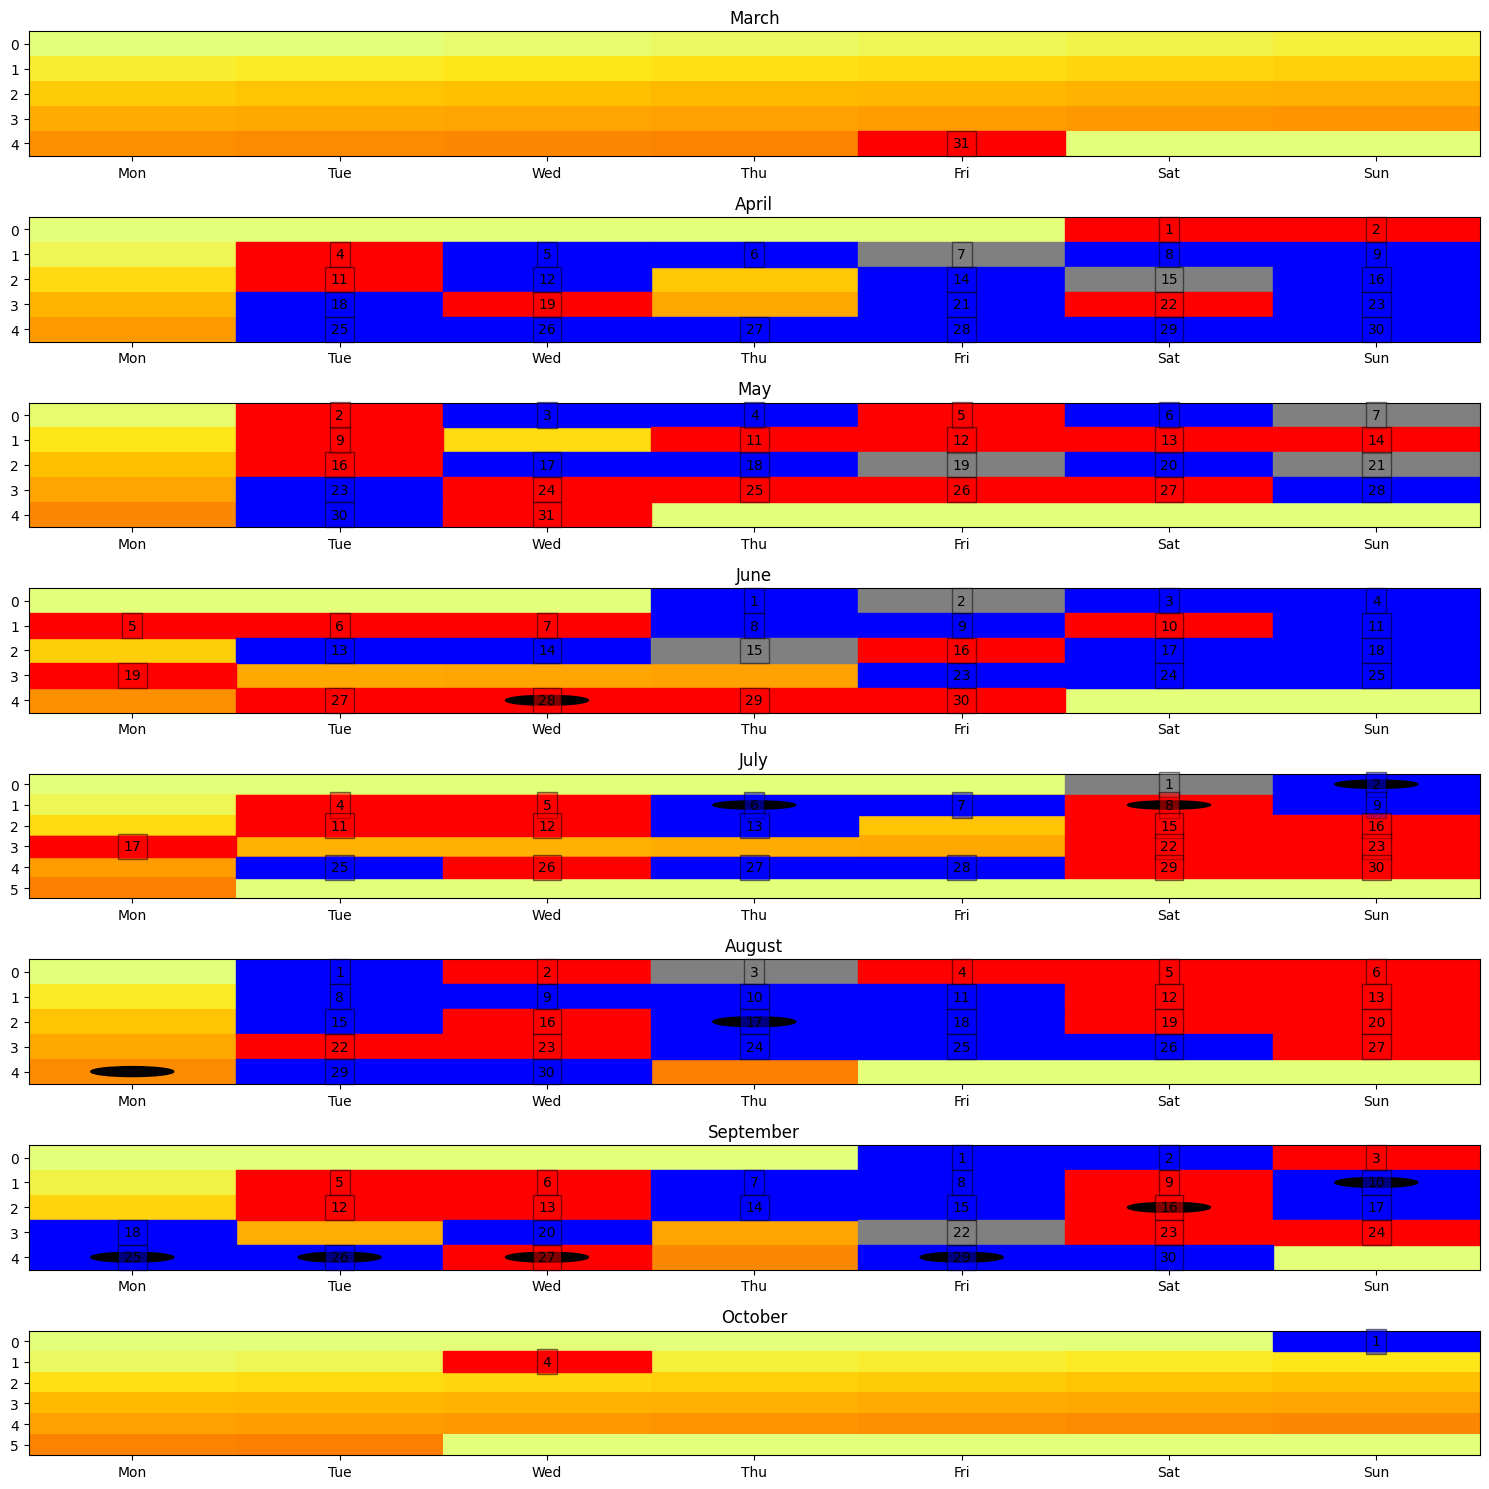

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
import sqlite3

# データベースファイルに接続
conn = sqlite3.connect('/Users/kose/dslast/dsprograming/scraped_data.db')

# 新しいデータベースファイルに接続（例えば 'example.db'）
conn_new = sqlite3.connect('/Users/kose/dslast/dsprograming/example.db')

# データベースからpandas DataFrameを読み込む
output_df = pd.read_sql_query("SELECT * FROM data", conn)

# 新しいデータベースからpandas DataFrameを読み込む
new_df = pd.read_sql_query("SELECT * FROM baseball_data", conn_new)


# output_dfのcol0を日付型に変換する
output_df['col0'] = pd.to_datetime(output_df['col0'] + '/2023', format='%m/%d/%Y')

# 新しいデータベースの日付データを解析する関数
def parse_new_db_date(date_str):
    # 新しいデータベースで日付が '〇〇月△△日' 形式であると仮定します
    # 年が含まれていないため、2023年を追加します
    date_str = '2023年' + date_str
    return datetime.strptime(date_str, '%Y年%m月%d日')

new_df['parsed_date'] = new_df['日付'].apply(parse_new_db_date)


# 勝敗に基づいて色をマッピングする関数
def get_color(win_loss_data):
    if win_loss_data == '○':
        return 'blue'  # 勝ち
    elif win_loss_data == '●':
        return 'red'  # 負け
    else:
        return 'grey'  # その他

# カレンダーの年月を設定
year = 2023
months = range(3, 11)  # 3月から10月

# カレンダーのプロット
fig, axs = plt.subplots(len(months), 1, figsize=(15, 15))
for i, month in enumerate(months):
    month_calendar = calendar.monthcalendar(year, month)
    ax = axs[i]
    ax.imshow(month_calendar, cmap='Wistia', interpolation='none', aspect='auto')
    ax.set_title(calendar.month_name[month])
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels(['Mon', 'Tue', 'Wed','Thu', 'Fri', 'Sat', 'Sun'])
    ax.set_yticks(np.arange(len(month_calendar)))

    for (j, week) in enumerate(month_calendar):
        for (k, day) in enumerate(week):
            if day != 0:
                # 日付を datetime 形式に変換
                date = datetime(year, month, day)

                # output_df から該当日のデータを取得
                day_data = output_df[(output_df['col0'].dt.year == year) &
                                     (output_df['col0'].dt.month == month) &
                                     (output_df['col0'].dt.day == day)]
                
                # new_df（新しいデータベース）から該当日のデータを取得
                new_day_data = new_df[new_df['parsed_date'] == date]


                # 勝敗データに基づいて色を取得
                if not day_data.empty:
                    color = get_color(day_data['col17'].values[0])
                    ax.add_patch(plt.Rectangle((k-0.5, j-0.5), 1, 1, color=color))
                    ax.text(k, j, str(day), ha='center', va='center', bbox=dict(facecolor=color, alpha=0.5))
                # 新しいデータベースのデータがあれば
                if not new_day_data.empty:
                    # 目印として円を描く。色やサイズは必要に応じて調整してください。
                    ax.add_patch(plt.Circle((k, j), 0.2, color='black', zorder=2))
                else:
                    # データがない場合は何もしない
                    continue

plt.tight_layout()
plt.show()